# Mask R-CNN - Train on Shapes Dataset


This notebook shows how to train Mask R-CNN on your own dataset. To keep things simple we use a synthetic dataset of shapes (squares, triangles, and circles) which enables fast training. You'd still need a GPU, though, because the network backbone is a Resnet101, which would be too slow to train on a CPU. On a GPU, you can start to get okay-ish results in a few minutes, and good results in less than an hour.

The code of the *Shapes* dataset is included below. It generates images on the fly, so it doesn't require downloading any data. And it can generate images of any size, so we pick a small image size to train faster. 

In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

Using TensorFlow backend.


## Configurations

In [2]:
class ShapesConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "shapes"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8

    # Number of classes (including background)
    NUM_CLASSES = 1 + 3  # background + 3 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 128
    IMAGE_MAX_DIM = 128

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
config = ShapesConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 8
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  128
IMAGE_META_SIZE                16
IMAGE_MIN_DIM                  128
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [128 128   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

## Notebook Preferences

In [3]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Dataset

Create a synthetic dataset

Extend the Dataset class and add a method to load the shapes dataset, `load_shapes()`, and override the following methods:

* load_image()
* load_mask()
* image_reference()

In [4]:
class ShapesDataset(utils.Dataset):
    """Generates the shapes synthetic dataset. The dataset consists of simple
    shapes (triangles, squares, circles) placed randomly on a blank surface.
    The images are generated on the fly. No file access required.
    """

    def load_shapes(self, count, height, width):
        """Generate the requested number of synthetic images.
        count: number of images to generate.
        height, width: the size of the generated images.
        """
        # Add classes
        self.add_class("shapes", 1, "square")
        self.add_class("shapes", 2, "circle")
        self.add_class("shapes", 3, "triangle")

        # Add images
        # Generate random specifications of images (i.e. color and
        # list of shapes sizes and locations). This is more compact than
        # actual images. Images are generated on the fly in load_image().
        for i in range(count):
            bg_color, shapes = self.random_image(height, width)
            self.add_image("shapes", image_id=i, path=None,
                           width=width, height=height,
                           bg_color=bg_color, shapes=shapes)

    def load_image(self, image_id):
        """Generate an image from the specs of the given image ID.
        Typically this function loads the image from a file, but
        in this case it generates the image on the fly from the
        specs in image_info.
        """
        info = self.image_info[image_id]
        bg_color = np.array(info['bg_color']).reshape([1, 1, 3])
        image = np.ones([info['height'], info['width'], 3], dtype=np.uint8)
        image = image * bg_color.astype(np.uint8)
        for shape, color, dims in info['shapes']:
            image = self.draw_shape(image, shape, dims, color)
        return image

    def image_reference(self, image_id):
        """Return the shapes data of the image."""
        info = self.image_info[image_id]
        if info["source"] == "shapes":
            return info["shapes"]
        else:
            super(self.__class__).image_reference(self, image_id)

    def load_mask(self, image_id):
        """Generate instance masks for shapes of the given image ID.
        """
        info = self.image_info[image_id]
        shapes = info['shapes']
        count = len(shapes)
        mask = np.zeros([info['height'], info['width'], count], dtype=np.uint8)
        for i, (shape, _, dims) in enumerate(info['shapes']):
            mask[:, :, i:i+1] = self.draw_shape(mask[:, :, i:i+1].copy(),
                                                shape, dims, 1)
        # Handle occlusions
        occlusion = np.logical_not(mask[:, :, -1]).astype(np.uint8)
        for i in range(count-2, -1, -1):
            mask[:, :, i] = mask[:, :, i] * occlusion
            occlusion = np.logical_and(occlusion, np.logical_not(mask[:, :, i]))
        # Map class names to class IDs.
        class_ids = np.array([self.class_names.index(s[0]) for s in shapes])
        return mask.astype(np.bool), class_ids.astype(np.int32)

    def draw_shape(self, image, shape, dims, color):
        """Draws a shape from the given specs."""
        # Get the center x, y and the size s
        x, y, s = dims
        if shape == 'square':
            cv2.rectangle(image, (x-s, y-s), (x+s, y+s), color, -1)
        elif shape == "circle":
            cv2.circle(image, (x, y), s, color, -1)
        elif shape == "triangle":
            points = np.array([[(x, y-s),
                                (x-s/math.sin(math.radians(60)), y+s),
                                (x+s/math.sin(math.radians(60)), y+s),
                                ]], dtype=np.int32)
            cv2.fillPoly(image, points, color)
        return image

    def random_shape(self, height, width):
        """Generates specifications of a random shape that lies within
        the given height and width boundaries.
        Returns a tuple of three valus:
        * The shape name (square, circle, ...)
        * Shape color: a tuple of 3 values, RGB.
        * Shape dimensions: A tuple of values that define the shape size
                            and location. Differs per shape type.
        """
        # Shape
        shape = random.choice(["square", "circle", "triangle"])
        # Color
        color = tuple([random.randint(0, 255) for _ in range(3)])
        # Center x, y
        buffer = 20
        y = random.randint(buffer, height - buffer - 1)
        x = random.randint(buffer, width - buffer - 1)
        # Size
        s = random.randint(buffer, height//4)
        return shape, color, (x, y, s)

    def random_image(self, height, width):
        """Creates random specifications of an image with multiple shapes.
        Returns the background color of the image and a list of shape
        specifications that can be used to draw the image.
        """
        # Pick random background color
        bg_color = np.array([random.randint(0, 255) for _ in range(3)])
        # Generate a few random shapes and record their
        # bounding boxes
        shapes = []
        boxes = []
        N = random.randint(1, 4)
        for _ in range(N):
            shape, color, dims = self.random_shape(height, width)
            shapes.append((shape, color, dims))
            x, y, s = dims
            boxes.append([y-s, x-s, y+s, x+s])
        # Apply non-max suppression wit 0.3 threshold to avoid
        # shapes covering each other
        keep_ixs = utils.non_max_suppression(np.array(boxes), np.arange(N), 0.3)
        shapes = [s for i, s in enumerate(shapes) if i in keep_ixs]
        return bg_color, shapes

In [5]:
# Training dataset
dataset_train = ShapesDataset()
dataset_train.load_shapes(500, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_train.prepare()

# Validation dataset
dataset_val = ShapesDataset()
dataset_val.load_shapes(50, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_val.prepare()

print("Train images:", len(dataset_train.image_ids))
print("Val images:", len(dataset_val.image_ids))


Train images: 500
Val images: 50


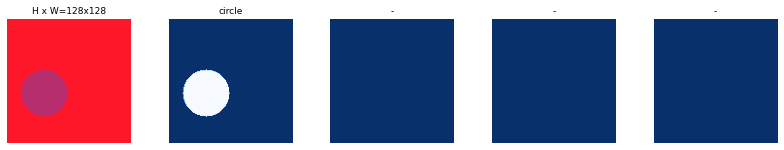

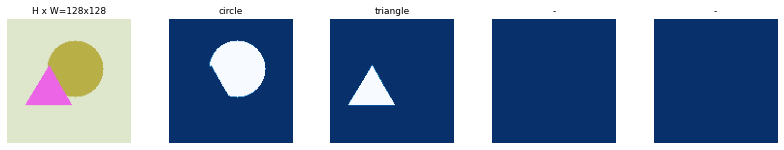

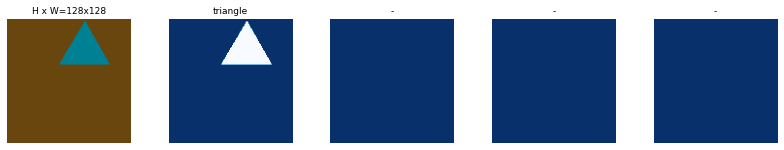

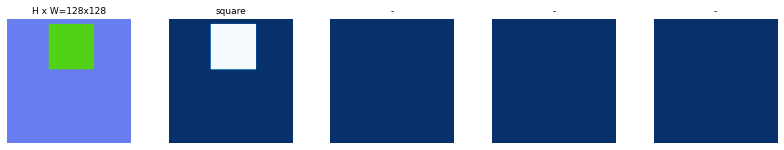

In [6]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

## Create Model

In [7]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead


In [8]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [9]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.


model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=1, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: D:\Mask_RCNN\logs\shapes20250417T2315\mask_rcnn_shapes_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4     

C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "






Epoch 1/1


C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order

  1/100 [..............................] - ETA: 31:21 - loss: 5.5413 - rpn_class_loss: 0.0663 - rpn_bbox_loss: 1.4893 - mrcnn_class_loss: 1.4594 - mrcnn_bbox_loss: 1.2095 - mrcnn_mask_loss: 1.3168

C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order

  2/100 [..............................] - ETA: 16:09 - loss: 5.9316 - rpn_class_loss: 0.0775 - rpn_bbox_loss: 1.8914 - mrcnn_class_loss: 1.3202 - mrcnn_bbox_loss: 1.3489 - mrcnn_mask_loss: 1.2937

C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order

  3/100 [..............................] - ETA: 11:04 - loss: 5.7622 - rpn_class_loss: 0.0821 - rpn_bbox_loss: 1.7862 - mrcnn_class_loss: 1.2612 - mrcnn_bbox_loss: 1.2914 - mrcnn_mask_loss: 1.3414

C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order

  4/100 [>.............................] - ETA: 8:31 - loss: 5.6079 - rpn_class_loss: 0.0841 - rpn_bbox_loss: 1.7044 - mrcnn_class_loss: 1.2343 - mrcnn_bbox_loss: 1.2528 - mrcnn_mask_loss: 1.3323 

C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order

  5/100 [>.............................] - ETA: 6:59 - loss: 5.3707 - rpn_class_loss: 0.0838 - rpn_bbox_loss: 1.6316 - mrcnn_class_loss: 1.1649 - mrcnn_bbox_loss: 1.1987 - mrcnn_mask_loss: 1.2917

C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order

  6/100 [>.............................] - ETA: 5:58 - loss: 5.2070 - rpn_class_loss: 0.0803 - rpn_bbox_loss: 1.5751 - mrcnn_class_loss: 1.0913 - mrcnn_bbox_loss: 1.1781 - mrcnn_mask_loss: 1.2821

C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order

  7/100 [=>............................] - ETA: 5:14 - loss: 5.0076 - rpn_class_loss: 0.0792 - rpn_bbox_loss: 1.4908 - mrcnn_class_loss: 1.0285 - mrcnn_bbox_loss: 1.1462 - mrcnn_mask_loss: 1.2629

C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order

  8/100 [=>............................] - ETA: 4:41 - loss: 4.8067 - rpn_class_loss: 0.0787 - rpn_bbox_loss: 1.3898 - mrcnn_class_loss: 0.9801 - mrcnn_bbox_loss: 1.1183 - mrcnn_mask_loss: 1.2398

C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order

  9/100 [=>............................] - ETA: 4:15 - loss: 4.7270 - rpn_class_loss: 0.0785 - rpn_bbox_loss: 1.4055 - mrcnn_class_loss: 0.9405 - mrcnn_bbox_loss: 1.0918 - mrcnn_mask_loss: 1.2108

C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order

 10/100 [==>...........................] - ETA: 3:54 - loss: 4.5924 - rpn_class_loss: 0.0770 - rpn_bbox_loss: 1.3502 - mrcnn_class_loss: 0.9127 - mrcnn_bbox_loss: 1.0743 - mrcnn_mask_loss: 1.1781

C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order

 11/100 [==>...........................] - ETA: 3:37 - loss: 4.5186 - rpn_class_loss: 0.0782 - rpn_bbox_loss: 1.3568 - mrcnn_class_loss: 0.8856 - mrcnn_bbox_loss: 1.0527 - mrcnn_mask_loss: 1.1453

C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order

 12/100 [==>...........................] - ETA: 3:22 - loss: 4.4052 - rpn_class_loss: 0.0775 - rpn_bbox_loss: 1.3166 - mrcnn_class_loss: 0.8607 - mrcnn_bbox_loss: 1.0332 - mrcnn_mask_loss: 1.1171

C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order

 13/100 [==>...........................] - ETA: 3:10 - loss: 4.2809 - rpn_class_loss: 0.0757 - rpn_bbox_loss: 1.2740 - mrcnn_class_loss: 0.8309 - mrcnn_bbox_loss: 1.0172 - mrcnn_mask_loss: 1.0831

C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order

 14/100 [===>..........................] - ETA: 3:00 - loss: 4.1742 - rpn_class_loss: 0.0743 - rpn_bbox_loss: 1.2294 - mrcnn_class_loss: 0.8123 - mrcnn_bbox_loss: 1.0040 - mrcnn_mask_loss: 1.0541

C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order

 15/100 [===>..........................] - ETA: 2:50 - loss: 4.0712 - rpn_class_loss: 0.0737 - rpn_bbox_loss: 1.1812 - mrcnn_class_loss: 0.7966 - mrcnn_bbox_loss: 0.9897 - mrcnn_mask_loss: 1.0301

C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order

 16/100 [===>..........................] - ETA: 2:42 - loss: 3.9609 - rpn_class_loss: 0.0719 - rpn_bbox_loss: 1.1483 - mrcnn_class_loss: 0.7631 - mrcnn_bbox_loss: 0.9701 - mrcnn_mask_loss: 1.0074

C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order

 17/100 [====>.........................] - ETA: 2:34 - loss: 3.8608 - rpn_class_loss: 0.0703 - rpn_bbox_loss: 1.1116 - mrcnn_class_loss: 0.7422 - mrcnn_bbox_loss: 0.9505 - mrcnn_mask_loss: 0.9862

C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order

 18/100 [====>.........................] - ETA: 2:27 - loss: 3.7732 - rpn_class_loss: 0.0693 - rpn_bbox_loss: 1.0829 - mrcnn_class_loss: 0.7213 - mrcnn_bbox_loss: 0.9336 - mrcnn_mask_loss: 0.9662

C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order

 19/100 [====>.........................] - ETA: 2:21 - loss: 3.6999 - rpn_class_loss: 0.0675 - rpn_bbox_loss: 1.0613 - mrcnn_class_loss: 0.7060 - mrcnn_bbox_loss: 0.9163 - mrcnn_mask_loss: 0.9487

C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order

 20/100 [=====>........................] - ETA: 2:16 - loss: 3.6298 - rpn_class_loss: 0.0670 - rpn_bbox_loss: 1.0382 - mrcnn_class_loss: 0.6941 - mrcnn_bbox_loss: 0.8976 - mrcnn_mask_loss: 0.9329

C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order

 21/100 [=====>........................] - ETA: 2:10 - loss: 3.5716 - rpn_class_loss: 0.0658 - rpn_bbox_loss: 1.0279 - mrcnn_class_loss: 0.6780 - mrcnn_bbox_loss: 0.8811 - mrcnn_mask_loss: 0.9188

C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order

 22/100 [=====>........................] - ETA: 2:06 - loss: 3.5134 - rpn_class_loss: 0.0656 - rpn_bbox_loss: 1.0119 - mrcnn_class_loss: 0.6684 - mrcnn_bbox_loss: 0.8634 - mrcnn_mask_loss: 0.9042

C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order

 23/100 [=====>........................] - ETA: 2:01 - loss: 3.4658 - rpn_class_loss: 0.0654 - rpn_bbox_loss: 1.0028 - mrcnn_class_loss: 0.6598 - mrcnn_bbox_loss: 0.8454 - mrcnn_mask_loss: 0.8925

C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order

 24/100 [======>.......................] - ETA: 1:57 - loss: 3.4047 - rpn_class_loss: 0.0638 - rpn_bbox_loss: 0.9827 - mrcnn_class_loss: 0.6484 - mrcnn_bbox_loss: 0.8305 - mrcnn_mask_loss: 0.8793

C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order

 25/100 [======>.......................] - ETA: 1:53 - loss: 3.3528 - rpn_class_loss: 0.0628 - rpn_bbox_loss: 0.9653 - mrcnn_class_loss: 0.6377 - mrcnn_bbox_loss: 0.8176 - mrcnn_mask_loss: 0.8693

C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order

 26/100 [======>.......................] - ETA: 1:50 - loss: 3.2896 - rpn_class_loss: 0.0618 - rpn_bbox_loss: 0.9444 - mrcnn_class_loss: 0.6253 - mrcnn_bbox_loss: 0.8011 - mrcnn_mask_loss: 0.8571

C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order

 27/100 [=======>......................] - ETA: 1:46 - loss: 3.2526 - rpn_class_loss: 0.0614 - rpn_bbox_loss: 0.9370 - mrcnn_class_loss: 0.6200 - mrcnn_bbox_loss: 0.7877 - mrcnn_mask_loss: 0.8465

C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order

 28/100 [=======>......................] - ETA: 1:43 - loss: 3.2062 - rpn_class_loss: 0.0607 - rpn_bbox_loss: 0.9232 - mrcnn_class_loss: 0.6107 - mrcnn_bbox_loss: 0.7753 - mrcnn_mask_loss: 0.8363

C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order

 29/100 [=======>......................] - ETA: 1:40 - loss: 3.1626 - rpn_class_loss: 0.0596 - rpn_bbox_loss: 0.9108 - mrcnn_class_loss: 0.6025 - mrcnn_bbox_loss: 0.7631 - mrcnn_mask_loss: 0.8266

C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order

 30/100 [========>.....................] - ETA: 1:37 - loss: 3.1124 - rpn_class_loss: 0.0582 - rpn_bbox_loss: 0.8955 - mrcnn_class_loss: 0.5889 - mrcnn_bbox_loss: 0.7512 - mrcnn_mask_loss: 0.8186

C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order

 31/100 [========>.....................] - ETA: 1:35 - loss: 3.0706 - rpn_class_loss: 0.0571 - rpn_bbox_loss: 0.8848 - mrcnn_class_loss: 0.5823 - mrcnn_bbox_loss: 0.7361 - mrcnn_mask_loss: 0.8104

C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order

 32/100 [========>.....................] - ETA: 1:32 - loss: 3.0278 - rpn_class_loss: 0.0562 - rpn_bbox_loss: 0.8716 - mrcnn_class_loss: 0.5761 - mrcnn_bbox_loss: 0.7230 - mrcnn_mask_loss: 0.8009

C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order

 33/100 [========>.....................] - ETA: 1:30 - loss: 2.9885 - rpn_class_loss: 0.0552 - rpn_bbox_loss: 0.8622 - mrcnn_class_loss: 0.5679 - mrcnn_bbox_loss: 0.7106 - mrcnn_mask_loss: 0.7925

C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order

 34/100 [=========>....................] - ETA: 1:27 - loss: 2.9535 - rpn_class_loss: 0.0544 - rpn_bbox_loss: 0.8518 - mrcnn_class_loss: 0.5611 - mrcnn_bbox_loss: 0.7004 - mrcnn_mask_loss: 0.7858

C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order

 35/100 [=========>....................] - ETA: 1:25 - loss: 2.9273 - rpn_class_loss: 0.0537 - rpn_bbox_loss: 0.8460 - mrcnn_class_loss: 0.5570 - mrcnn_bbox_loss: 0.6922 - mrcnn_mask_loss: 0.7784

C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order

 36/100 [=========>....................] - ETA: 1:23 - loss: 2.8926 - rpn_class_loss: 0.0526 - rpn_bbox_loss: 0.8394 - mrcnn_class_loss: 0.5495 - mrcnn_bbox_loss: 0.6805 - mrcnn_mask_loss: 0.7706

C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order

 37/100 [==========>...................] - ETA: 1:20 - loss: 2.8633 - rpn_class_loss: 0.0518 - rpn_bbox_loss: 0.8280 - mrcnn_class_loss: 0.5467 - mrcnn_bbox_loss: 0.6730 - mrcnn_mask_loss: 0.7638

C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order

 38/100 [==========>...................] - ETA: 1:18 - loss: 2.8346 - rpn_class_loss: 0.0510 - rpn_bbox_loss: 0.8221 - mrcnn_class_loss: 0.5388 - mrcnn_bbox_loss: 0.6655 - mrcnn_mask_loss: 0.7571

C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order

 39/100 [==========>...................] - ETA: 1:16 - loss: 2.8014 - rpn_class_loss: 0.0503 - rpn_bbox_loss: 0.8152 - mrcnn_class_loss: 0.5315 - mrcnn_bbox_loss: 0.6542 - mrcnn_mask_loss: 0.7503

C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order

 40/100 [===========>..................] - ETA: 1:14 - loss: 2.7665 - rpn_class_loss: 0.0494 - rpn_bbox_loss: 0.8038 - mrcnn_class_loss: 0.5250 - mrcnn_bbox_loss: 0.6446 - mrcnn_mask_loss: 0.7436

C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order

 41/100 [===========>..................] - ETA: 1:12 - loss: 2.7361 - rpn_class_loss: 0.0488 - rpn_bbox_loss: 0.7953 - mrcnn_class_loss: 0.5188 - mrcnn_bbox_loss: 0.6362 - mrcnn_mask_loss: 0.7371

C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order

 42/100 [===========>..................] - ETA: 1:11 - loss: 2.7100 - rpn_class_loss: 0.0484 - rpn_bbox_loss: 0.7914 - mrcnn_class_loss: 0.5117 - mrcnn_bbox_loss: 0.6278 - mrcnn_mask_loss: 0.7307

C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order

 43/100 [===========>..................] - ETA: 1:09 - loss: 2.6760 - rpn_class_loss: 0.0474 - rpn_bbox_loss: 0.7832 - mrcnn_class_loss: 0.5027 - mrcnn_bbox_loss: 0.6183 - mrcnn_mask_loss: 0.7243

C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order

 44/100 [============>.................] - ETA: 1:07 - loss: 2.6527 - rpn_class_loss: 0.0468 - rpn_bbox_loss: 0.7778 - mrcnn_class_loss: 0.4991 - mrcnn_bbox_loss: 0.6105 - mrcnn_mask_loss: 0.7184

C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order

 45/100 [============>.................] - ETA: 1:05 - loss: 2.6235 - rpn_class_loss: 0.0461 - rpn_bbox_loss: 0.7698 - mrcnn_class_loss: 0.4910 - mrcnn_bbox_loss: 0.6035 - mrcnn_mask_loss: 0.7131

C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order

 46/100 [============>.................] - ETA: 1:04 - loss: 2.5951 - rpn_class_loss: 0.0454 - rpn_bbox_loss: 0.7622 - mrcnn_class_loss: 0.4846 - mrcnn_bbox_loss: 0.5956 - mrcnn_mask_loss: 0.7073

C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order

 47/100 [=============>................] - ETA: 1:02 - loss: 2.5726 - rpn_class_loss: 0.0448 - rpn_bbox_loss: 0.7561 - mrcnn_class_loss: 0.4801 - mrcnn_bbox_loss: 0.5893 - mrcnn_mask_loss: 0.7022

C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order

 48/100 [=============>................] - ETA: 1:00 - loss: 2.5498 - rpn_class_loss: 0.0442 - rpn_bbox_loss: 0.7520 - mrcnn_class_loss: 0.4732 - mrcnn_bbox_loss: 0.5836 - mrcnn_mask_loss: 0.6968

C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order

 49/100 [=============>................] - ETA: 59s - loss: 2.5349 - rpn_class_loss: 0.0437 - rpn_bbox_loss: 0.7475 - mrcnn_class_loss: 0.4711 - mrcnn_bbox_loss: 0.5793 - mrcnn_mask_loss: 0.6933 

C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order

 50/100 [==============>...............] - ETA: 57s - loss: 2.5138 - rpn_class_loss: 0.0432 - rpn_bbox_loss: 0.7412 - mrcnn_class_loss: 0.4676 - mrcnn_bbox_loss: 0.5735 - mrcnn_mask_loss: 0.6882

C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order

 51/100 [==============>...............] - ETA: 56s - loss: 2.4962 - rpn_class_loss: 0.0428 - rpn_bbox_loss: 0.7383 - mrcnn_class_loss: 0.4638 - mrcnn_bbox_loss: 0.5682 - mrcnn_mask_loss: 0.6832

C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order

 52/100 [==============>...............] - ETA: 54s - loss: 2.4751 - rpn_class_loss: 0.0421 - rpn_bbox_loss: 0.7330 - mrcnn_class_loss: 0.4594 - mrcnn_bbox_loss: 0.5629 - mrcnn_mask_loss: 0.6777

C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order

 53/100 [==============>...............] - ETA: 53s - loss: 2.4565 - rpn_class_loss: 0.0418 - rpn_bbox_loss: 0.7290 - mrcnn_class_loss: 0.4552 - mrcnn_bbox_loss: 0.5576 - mrcnn_mask_loss: 0.6728

C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order

 54/100 [===============>..............] - ETA: 52s - loss: 2.4398 - rpn_class_loss: 0.0414 - rpn_bbox_loss: 0.7255 - mrcnn_class_loss: 0.4520 - mrcnn_bbox_loss: 0.5527 - mrcnn_mask_loss: 0.6682

C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order

 55/100 [===============>..............] - ETA: 50s - loss: 2.4192 - rpn_class_loss: 0.0409 - rpn_bbox_loss: 0.7197 - mrcnn_class_loss: 0.4486 - mrcnn_bbox_loss: 0.5468 - mrcnn_mask_loss: 0.6632

C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order

 56/100 [===============>..............] - ETA: 49s - loss: 2.4031 - rpn_class_loss: 0.0405 - rpn_bbox_loss: 0.7156 - mrcnn_class_loss: 0.4463 - mrcnn_bbox_loss: 0.5417 - mrcnn_mask_loss: 0.6591

C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order

 57/100 [================>.............] - ETA: 47s - loss: 2.3873 - rpn_class_loss: 0.0404 - rpn_bbox_loss: 0.7111 - mrcnn_class_loss: 0.4450 - mrcnn_bbox_loss: 0.5366 - mrcnn_mask_loss: 0.6542

C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order

 58/100 [================>.............] - ETA: 46s - loss: 2.3719 - rpn_class_loss: 0.0400 - rpn_bbox_loss: 0.7083 - mrcnn_class_loss: 0.4418 - mrcnn_bbox_loss: 0.5314 - mrcnn_mask_loss: 0.6504

C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order

 59/100 [================>.............] - ETA: 45s - loss: 2.3537 - rpn_class_loss: 0.0396 - rpn_bbox_loss: 0.7050 - mrcnn_class_loss: 0.4385 - mrcnn_bbox_loss: 0.5254 - mrcnn_mask_loss: 0.6453

C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order

 60/100 [=================>............] - ETA: 43s - loss: 2.3417 - rpn_class_loss: 0.0393 - rpn_bbox_loss: 0.7029 - mrcnn_class_loss: 0.4365 - mrcnn_bbox_loss: 0.5221 - mrcnn_mask_loss: 0.6409

C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order

 61/100 [=================>............] - ETA: 42s - loss: 2.3248 - rpn_class_loss: 0.0390 - rpn_bbox_loss: 0.6981 - mrcnn_class_loss: 0.4327 - mrcnn_bbox_loss: 0.5172 - mrcnn_mask_loss: 0.6379

C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order

 62/100 [=================>............] - ETA: 41s - loss: 2.3112 - rpn_class_loss: 0.0387 - rpn_bbox_loss: 0.6938 - mrcnn_class_loss: 0.4310 - mrcnn_bbox_loss: 0.5128 - mrcnn_mask_loss: 0.6349

C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order

 63/100 [=================>............] - ETA: 40s - loss: 2.2948 - rpn_class_loss: 0.0384 - rpn_bbox_loss: 0.6896 - mrcnn_class_loss: 0.4275 - mrcnn_bbox_loss: 0.5081 - mrcnn_mask_loss: 0.6312

C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order

 64/100 [==================>...........] - ETA: 38s - loss: 2.2798 - rpn_class_loss: 0.0381 - rpn_bbox_loss: 0.6860 - mrcnn_class_loss: 0.4244 - mrcnn_bbox_loss: 0.5037 - mrcnn_mask_loss: 0.6275

C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order

 65/100 [==================>...........] - ETA: 37s - loss: 2.2648 - rpn_class_loss: 0.0378 - rpn_bbox_loss: 0.6838 - mrcnn_class_loss: 0.4204 - mrcnn_bbox_loss: 0.4990 - mrcnn_mask_loss: 0.6237

C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order

 66/100 [==================>...........] - ETA: 36s - loss: 2.2489 - rpn_class_loss: 0.0375 - rpn_bbox_loss: 0.6799 - mrcnn_class_loss: 0.4172 - mrcnn_bbox_loss: 0.4945 - mrcnn_mask_loss: 0.6199

C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order

 67/100 [===================>..........] - ETA: 35s - loss: 2.2365 - rpn_class_loss: 0.0372 - rpn_bbox_loss: 0.6760 - mrcnn_class_loss: 0.4165 - mrcnn_bbox_loss: 0.4905 - mrcnn_mask_loss: 0.6163

C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order

 68/100 [===================>..........] - ETA: 33s - loss: 2.2197 - rpn_class_loss: 0.0368 - rpn_bbox_loss: 0.6719 - mrcnn_class_loss: 0.4131 - mrcnn_bbox_loss: 0.4857 - mrcnn_mask_loss: 0.6122

C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order

 69/100 [===================>..........] - ETA: 32s - loss: 2.2066 - rpn_class_loss: 0.0365 - rpn_bbox_loss: 0.6683 - mrcnn_class_loss: 0.4103 - mrcnn_bbox_loss: 0.4824 - mrcnn_mask_loss: 0.6090

C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order

 70/100 [====================>.........] - ETA: 31s - loss: 2.1945 - rpn_class_loss: 0.0362 - rpn_bbox_loss: 0.6654 - mrcnn_class_loss: 0.4075 - mrcnn_bbox_loss: 0.4785 - mrcnn_mask_loss: 0.6068

C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order

 71/100 [====================>.........] - ETA: 30s - loss: 2.1807 - rpn_class_loss: 0.0359 - rpn_bbox_loss: 0.6606 - mrcnn_class_loss: 0.4053 - mrcnn_bbox_loss: 0.4753 - mrcnn_mask_loss: 0.6037

C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order

 72/100 [====================>.........] - ETA: 29s - loss: 2.1662 - rpn_class_loss: 0.0357 - rpn_bbox_loss: 0.6571 - mrcnn_class_loss: 0.4017 - mrcnn_bbox_loss: 0.4716 - mrcnn_mask_loss: 0.6001

C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order

 73/100 [====================>.........] - ETA: 28s - loss: 2.1548 - rpn_class_loss: 0.0355 - rpn_bbox_loss: 0.6537 - mrcnn_class_loss: 0.3991 - mrcnn_bbox_loss: 0.4684 - mrcnn_mask_loss: 0.5981

C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order

 74/100 [=====================>........] - ETA: 27s - loss: 2.1410 - rpn_class_loss: 0.0353 - rpn_bbox_loss: 0.6497 - mrcnn_class_loss: 0.3963 - mrcnn_bbox_loss: 0.4649 - mrcnn_mask_loss: 0.5949

C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order

 75/100 [=====================>........] - ETA: 26s - loss: 2.1308 - rpn_class_loss: 0.0350 - rpn_bbox_loss: 0.6477 - mrcnn_class_loss: 0.3935 - mrcnn_bbox_loss: 0.4623 - mrcnn_mask_loss: 0.5922

C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order

 76/100 [=====================>........] - ETA: 24s - loss: 2.1190 - rpn_class_loss: 0.0348 - rpn_bbox_loss: 0.6456 - mrcnn_class_loss: 0.3901 - mrcnn_bbox_loss: 0.4596 - mrcnn_mask_loss: 0.5889

C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order

 77/100 [======================>.......] - ETA: 23s - loss: 2.1098 - rpn_class_loss: 0.0346 - rpn_bbox_loss: 0.6427 - mrcnn_class_loss: 0.3879 - mrcnn_bbox_loss: 0.4573 - mrcnn_mask_loss: 0.5872

C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order

 78/100 [======================>.......] - ETA: 22s - loss: 2.1006 - rpn_class_loss: 0.0344 - rpn_bbox_loss: 0.6400 - mrcnn_class_loss: 0.3863 - mrcnn_bbox_loss: 0.4548 - mrcnn_mask_loss: 0.5852

C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order

 79/100 [======================>.......] - ETA: 21s - loss: 2.0907 - rpn_class_loss: 0.0342 - rpn_bbox_loss: 0.6383 - mrcnn_class_loss: 0.3837 - mrcnn_bbox_loss: 0.4520 - mrcnn_mask_loss: 0.5824

C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order

 80/100 [=======================>......] - ETA: 20s - loss: 2.0783 - rpn_class_loss: 0.0340 - rpn_bbox_loss: 0.6353 - mrcnn_class_loss: 0.3800 - mrcnn_bbox_loss: 0.4497 - mrcnn_mask_loss: 0.5793

C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order

 81/100 [=======================>......] - ETA: 19s - loss: 2.0684 - rpn_class_loss: 0.0338 - rpn_bbox_loss: 0.6319 - mrcnn_class_loss: 0.3779 - mrcnn_bbox_loss: 0.4477 - mrcnn_mask_loss: 0.5771

C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order

 82/100 [=======================>......] - ETA: 18s - loss: 2.0577 - rpn_class_loss: 0.0336 - rpn_bbox_loss: 0.6309 - mrcnn_class_loss: 0.3749 - mrcnn_bbox_loss: 0.4446 - mrcnn_mask_loss: 0.5738

C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order

 83/100 [=======================>......] - ETA: 17s - loss: 2.0455 - rpn_class_loss: 0.0333 - rpn_bbox_loss: 0.6279 - mrcnn_class_loss: 0.3718 - mrcnn_bbox_loss: 0.4414 - mrcnn_mask_loss: 0.5711

C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order

 84/100 [========================>.....] - ETA: 16s - loss: 2.0371 - rpn_class_loss: 0.0331 - rpn_bbox_loss: 0.6276 - mrcnn_class_loss: 0.3696 - mrcnn_bbox_loss: 0.4390 - mrcnn_mask_loss: 0.5678

C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order

 85/100 [========================>.....] - ETA: 15s - loss: 2.0260 - rpn_class_loss: 0.0329 - rpn_bbox_loss: 0.6254 - mrcnn_class_loss: 0.3667 - mrcnn_bbox_loss: 0.4358 - mrcnn_mask_loss: 0.5653

C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order

 86/100 [========================>.....] - ETA: 14s - loss: 2.0169 - rpn_class_loss: 0.0327 - rpn_bbox_loss: 0.6238 - mrcnn_class_loss: 0.3642 - mrcnn_bbox_loss: 0.4333 - mrcnn_mask_loss: 0.5629

C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order

 87/100 [=========================>....] - ETA: 13s - loss: 2.0072 - rpn_class_loss: 0.0324 - rpn_bbox_loss: 0.6220 - mrcnn_class_loss: 0.3613 - mrcnn_bbox_loss: 0.4304 - mrcnn_mask_loss: 0.5610

C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order

 88/100 [=========================>....] - ETA: 12s - loss: 1.9973 - rpn_class_loss: 0.0323 - rpn_bbox_loss: 0.6209 - mrcnn_class_loss: 0.3586 - mrcnn_bbox_loss: 0.4275 - mrcnn_mask_loss: 0.5580

C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order

 89/100 [=========================>....] - ETA: 11s - loss: 1.9870 - rpn_class_loss: 0.0321 - rpn_bbox_loss: 0.6193 - mrcnn_class_loss: 0.3561 - mrcnn_bbox_loss: 0.4243 - mrcnn_mask_loss: 0.5552

C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order

 90/100 [==========================>...] - ETA: 10s - loss: 1.9775 - rpn_class_loss: 0.0320 - rpn_bbox_loss: 0.6182 - mrcnn_class_loss: 0.3528 - mrcnn_bbox_loss: 0.4215 - mrcnn_mask_loss: 0.5531

C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order

 91/100 [==========================>...] - ETA: 9s - loss: 1.9653 - rpn_class_loss: 0.0318 - rpn_bbox_loss: 0.6157 - mrcnn_class_loss: 0.3497 - mrcnn_bbox_loss: 0.4182 - mrcnn_mask_loss: 0.5498 

C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order

 92/100 [==========================>...] - ETA: 7s - loss: 1.9558 - rpn_class_loss: 0.0316 - rpn_bbox_loss: 0.6146 - mrcnn_class_loss: 0.3472 - mrcnn_bbox_loss: 0.4150 - mrcnn_mask_loss: 0.5474

C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order

 93/100 [==========================>...] - ETA: 6s - loss: 1.9472 - rpn_class_loss: 0.0315 - rpn_bbox_loss: 0.6132 - mrcnn_class_loss: 0.3447 - mrcnn_bbox_loss: 0.4121 - mrcnn_mask_loss: 0.5457

C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order

 94/100 [===========================>..] - ETA: 5s - loss: 1.9377 - rpn_class_loss: 0.0313 - rpn_bbox_loss: 0.6108 - mrcnn_class_loss: 0.3423 - mrcnn_bbox_loss: 0.4097 - mrcnn_mask_loss: 0.5436

C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order

 95/100 [===========================>..] - ETA: 4s - loss: 1.9314 - rpn_class_loss: 0.0313 - rpn_bbox_loss: 0.6094 - mrcnn_class_loss: 0.3405 - mrcnn_bbox_loss: 0.4077 - mrcnn_mask_loss: 0.5424

C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order

 96/100 [===========================>..] - ETA: 3s - loss: 1.9234 - rpn_class_loss: 0.0312 - rpn_bbox_loss: 0.6078 - mrcnn_class_loss: 0.3385 - mrcnn_bbox_loss: 0.4053 - mrcnn_mask_loss: 0.5407

C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order

 97/100 [============================>.] - ETA: 2s - loss: 1.9167 - rpn_class_loss: 0.0311 - rpn_bbox_loss: 0.6063 - mrcnn_class_loss: 0.3363 - mrcnn_bbox_loss: 0.4038 - mrcnn_mask_loss: 0.5391

C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order

 98/100 [============================>.] - ETA: 1s - loss: 1.9087 - rpn_class_loss: 0.0309 - rpn_bbox_loss: 0.6036 - mrcnn_class_loss: 0.3348 - mrcnn_bbox_loss: 0.4020 - mrcnn_mask_loss: 0.5374

C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order

 99/100 [============================>.] - ETA: 0s - loss: 1.8982 - rpn_class_loss: 0.0307 - rpn_bbox_loss: 0.6008 - mrcnn_class_loss: 0.3324 - mrcnn_bbox_loss: 0.3992 - mrcnn_mask_loss: 0.5350

C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order

C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Sofiane\anaconda3\envs\MaskRcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order

100/100 [==============================] - 103s 1s/step - loss: 1.8927 - rpn_class_loss: 0.0306 - rpn_bbox_loss: 0.5996 - mrcnn_class_loss: 0.3306 - mrcnn_bbox_loss: 0.3977 - mrcnn_mask_loss: 0.5342 - val_loss: 1.1360 - val_rpn_class_loss: 0.0156 - val_rpn_bbox_loss: 0.4581 - val_mrcnn_class_loss: 0.1393 - val_mrcnn_bbox_loss: 0.1841 - val_mrcnn_mask_loss: 0.3389



In [ ]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=2, 
            layers="all")

In [ ]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
# model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes.h5")
# model.keras_model.save_weights(model_path)

## Detection

In [10]:
class InferenceConfig(ShapesConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)



Instructions for updating:
Use `tf.cast` instead.
Loading weights from  D:\Mask_RCNN\logs\shapes20250417T2315\mask_rcnn_shapes_0001.h5
Re-starting from epoch 1


original_image           shape: (128, 128, 3)         min:   22.00000  max:  252.00000  uint8
image_meta               shape: (16,)                 min:    0.00000  max:  128.00000  int32
gt_class_id              shape: (2,)                  min:    1.00000  max:    2.00000  int32
gt_bbox                  shape: (2, 4)                min:    5.00000  max:  117.00000  int32
gt_mask                  shape: (128, 128, 2)         min:    0.00000  max:    1.00000  bool


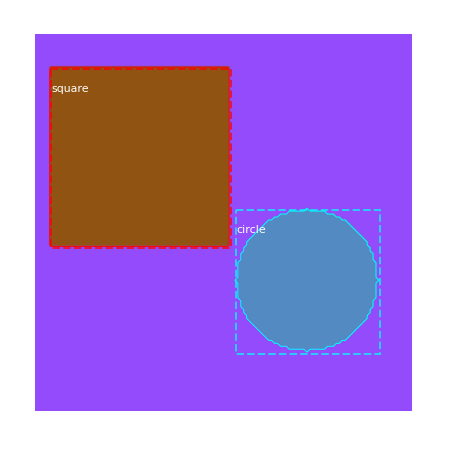

In [12]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (128, 128, 3)         min:   22.00000  max:  252.00000  uint8
molded_images            shape: (1, 128, 128, 3)      min:  -94.80000  max:  148.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  128.00000  int32
anchors                  shape: (1, 4092, 4)          min:   -0.71267  max:    1.20874  float32


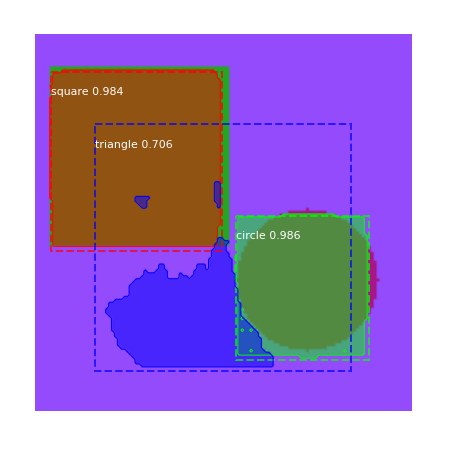

In [14]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

## Evaluation

In [15]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

mAP:  0.96875
